1.1.1
0.9.6


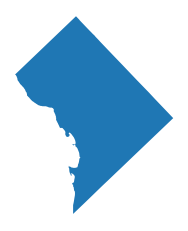

In [1]:
import folium
import openrouteservice as ors
import sys
import heapq
import random, math

%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import pysal as ps


import pandas as pd
import osmnx as ox
city = ox.geocode_to_gdf('Washington, D.C.')
ax = ox.project_gdf(city).plot()
_ = ax.axis('off')


import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd

import networkx as nx

import igraph as ig
print(ox.__version__)
print(ig.__version__)

weight = "length"


import numpy
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform 


In [2]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
my_map = gpd.read_file('Snow_Removal_Areas.kml', driver='KML')
my_map

,Name,Description,geometry
0,,,"POLYGON ((-77.00884 38.95484, -77.00866 38.954..."
1,,,"POLYGON ((-76.98949 38.94730, -76.98932 38.947..."
2,,,"POLYGON ((-77.00868 38.94796, -77.00870 38.948..."
3,,,"POLYGON ((-77.00595 38.95549, -77.00611 38.955..."
4,,,"POLYGON ((-76.98145 38.94078, -76.98165 38.940..."
...,...,...,...
77,,,"POLYGON ((-77.02132 38.94811, -77.02107 38.948..."
78,,,"POLYGON ((-77.02270 38.94625, -77.02283 38.946..."
79,,,"POLYGON ((-77.03779 38.93769, -77.03771 38.937..."
80,,,"POLYGON ((-76.98398 38.87971, -76.98427 38.879..."


In [3]:
polys = []
coordinates = []

In [4]:
for i in range( len(my_map)):
    polys.append(my_map.iloc[i])
    coordinates.append(polys[i][2])

In [5]:
Graphs = []

In [6]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 20:31:07


In [7]:
for i in range(len(coordinates)):
    Graphs.append(ox.graph_from_polygon(coordinates[i], network_type="drive",
                            simplify=True, retain_all=True, truncate_by_edge=True, 
                            clean_periphery=True, custom_filter=None))

In [8]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 20:33:12


In [9]:
denseGraphs1 = []

In [10]:
Graphs2 = []

In [11]:
Graphs2 = Graphs.copy()

In [12]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 20:33:12


In [13]:
for i in range(len(Graphs)):
    G_proj = ox.project_graph(Graphs[i])
    dense = ox.consolidate_intersections(G_proj, rebuild_graph=False, tolerance=15, dead_ends=False)
    denseGraphs1.append(dense)
    

In [14]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 20:33:45


In [15]:
nxGraphs = []

In [16]:
denseGraphs = denseGraphs1

In [17]:
idenseGraphs = []

In [18]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 20:33:45


In [19]:
for i in range(len(Graphs)):
    osmids = list(Graphs[i].nodes)
    Graphs[i] = nx.relabel.convert_node_labels_to_integers(Graphs[i])
    osmid_values = {k: v for k, v in zip(Graphs[i].nodes, osmids)}
    nx.set_node_attributes(Graphs[i], osmid_values, "osmid")

In [20]:
numberOfAreas = len(Graphs)

In [21]:
numberOfAreas

82

In [22]:
for i in range(numberOfAreas):
    idenseGraphs.insert( i, ig.Graph(directed=True))
    idenseGraphs[i].add_vertices(Graphs[i].nodes)
    idenseGraphs[i].add_edges(Graphs[i].edges())
    idenseGraphs[i].vs["osmid"] = osmids
    idenseGraphs[i].es[weight] = list(nx.get_edge_attributes(Graphs[i], weight).values())

In [23]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 20:33:45


In [24]:
eccentricities = []
neighbors = []

In [25]:
for i in range(len(idenseGraphs)):
    eccentricities.append(idenseGraphs[i].eccentricity(vertices=None, mode='in'))
    neighbors.append(idenseGraphs[i].neighborhood(vertices=None, order=1, mode='all', mindist=0))

In [26]:
len(eccentricities)

82

In [27]:
df1 = pd.DataFrame()
Nodes = []

In [28]:
df1 = pd.DataFrame()
Nodes = []

G23 = Graphs[3]
for i in G23.nodes:
    Nodes.append(i)
df1 = pd.DataFrame(Nodes)
df1.rename(columns = {0:'Nodes'}, inplace = True)

df1 = pd.DataFrame(Nodes)

df1.rename(columns = {0:'Nodes'}, inplace = True)

lats = []
longs = []

for i in Nodes:
    lats.append(G23.nodes[i].get('y'))
    longs.append(G23.nodes[i].get('x'))
    
df1['Latitude'] = lats
df1['Longitude'] = longs

df1.head()

subset = df1[['Latitude', 'Longitude']]
tuples = [tuple(x) for x in subset.to_numpy()]

len(tuples)

166

In [29]:
arrayofTuples = numpy.array_split(tuples, 5)

In [30]:
arrayofEccentricity = numpy.array_split(eccentricities[0], 5)

In [31]:
class PrioritySet(object):
    
    def __init__(self):
        self.heap = []
        self.set = set()

    def push(self, d):
        if not d in self.set:
            heapq.heappush(self.heap, d)
            self.set.add(d)

    def pop(self):
        d = heapq.heappop(self.heap)
        self.set.remove(d)
        return d

    def size(self):
        return len(self.heap)

    def __str__(self):
        op = ""
        for i in self.heap:
            op += str(i[0]) + " : " + i[1].__str__()
            op += "\n"
        return op

    def __getitem__(self, index):
        return self.heap[index]

In [32]:
class Position:

    def __init__(self,x,y):
        self.x = x
        self.y = y		

    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ") "

    def x_coor(self):
        return self.x

    def y_coor(self):
        return self.y

In [33]:
class Vehicle:

    def __init__(self, capacity):
        self.capacity = capacity

    def capacity(self):
        return self.capacity

In [34]:
class Node:

    pos = Position(-1,-1)
    demand = 0

    def __init__(self,name):
        self.name = name

    def setPosition(self,x,y):
        self.pos = Position(x, y)

    def setDemand(self,d):
        self.demand = d

    def __str__(self):
        return "( " + str(self.pos.x) + " , " + \
                   str(self.pos.y) + " )"

In [35]:
def copy(li):
    return [i for i in li]

def getProb():
    return random.random()

def get_random(li):
    index = random.randint(0, len(li)-1)
    return li[index]

def get_distance(cus1, cus2):
    # Euclideian
    #change to vincenty later
    dist = 0 
    dist = math.sqrt(((cus1.pos.x - cus2.pos.x) ** 2) + ((cus1.pos.y - cus2.pos.y) ** 2))
    return dist

def print_tuple(t):
#     print( "0"), 
    for i in t:
        print(i),        
#     print( "0"),
#     print (" -> f: " + str(get_fitness(t)))

def print_population(p):
    for i in p:
        for c in i:
            print(c),
        print("\n")
    
def print_population_heap(p):
    count = 1
    for i in p:
        print (count, " )  ")
        print_tuple(i[1])
        count += 1
        print("\n")



In [36]:
def mutate(chromosome):

    temp = [i for i in chromosome]
    
    if getProb() < MUTATION_RATE:
        left = random.randint(1, len(temp) - 2)
        right = random.randint(left, len(temp) - 1)   
        temp[left], temp[right] = temp[right], temp[left]
    return temp


In [37]:

def crossover(a,b):

    if getProb() < CROSSOVER_RATE:
        left = random.randint(1, len(a) - 2)
        right = random.randint(left, len(a) - 1)
        # print left, " ", right
        c1 = [c for c in a[0:] if c not in b[left:right+1]]
        # print len(c1)
        a1 = c1[:left] + b[left:right+1] + c1[left:]
        # print len(p1)
        c2 = [c for c in b[0:] if c not in a[left:right+1]]
        b1 = c2[:left] + a[left:right+1] + c2[left:]
        return a1, b1
       
    return a, b


In [38]:

def get_fitness(li):
    
    num_custo = len(li)
    fitness = 0

    for i in range(num_custo - 1):
        fitness += get_distance(li[i], li[i+1])

    fitness += get_distance(DEPOT, li[0])
    fitness += get_distance(li[-1], DEPOT)

    temp = copy(li)
    temp.insert(0,DEPOT)
    temp.append(DEPOT)
    valid = 1
    curr_demand = 0
    for i in range(len(temp)):
        if temp[i] == DEPOT and curr_demand > CAPACITY:
            fitness = INF
        elif temp[i] == DEPOT:
            curr_demand = 0
        else:
            curr_demand += temp[i].demand

    return fitness

In [39]:

def getPopulationFitness(p):
    
    h = PrioritySet()
    for i in p:
        h.push((get_fitness(i),i))
    return h

def create_new():

    TempSet = copy(Nodes)
    chromosome = []
    while len(TempSet) > 0:
        index = (int)(getProb() * len(TempSet))
        chromosome.append(TempSet.pop(index))

    return chromosome 

In [40]:

def initialize_population():

    while len(population) < POPULATION_SIZE:
        TempSet = copy(Nodes)
        chromosome = []
        while len(TempSet) > 0:
            index = (int)(getProb() * len(TempSet))
            chromosome.append(TempSet.pop(index))

        if get_fitness(chromosome) != INF:
            population.add(tuple(chromosome))

In [41]:
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.9
POPULATION_SIZE = 100
FITNESS = 0
TRUCKS = 15
DEPOT = None
CAPACITY = 100
INF = float("inf")

In [42]:

def Genetic_Algo():

#     print ("POPULATION GENERATED... EVOLUTION BEGINING ...")
    minimum_chrom = h[0]
#     print( "Curr Min: ", minimum_chrom[0])
    count = 0
    # while h[0][0] > 1800:
    while count < 1000:
        ax = h.pop()
        bx = h.pop()
        a,b = crossover(list(ax[1]),list(bx[1]))
        a = mutate(a)
        while get_fitness(a) == INF:
            a = create_new()
        b = mutate(b)
        while get_fitness(b) == INF:
            b = create_new()
        if get_fitness(a) != INF:
            h.push((get_fitness(a),tuple(a)))
        else:
            h.push(ax)
        if get_fitness(b) != INF:
            h.push((get_fitness(b),tuple(b)))
        else:
            h.push(bx)

        while h.size() < POPULATION_SIZE:
            TempSet = copy(Nodes)
            chromosome = []
            count += 1
            while len(TempSet) > 0:
                index = (int)(getProb() * len(TempSet))
                chromosome.append(TempSet.pop(index))
            h.push((get_fitness(chromosome),tuple(chromosome)))
        count = count + 1
        if h[0][0] < minimum_chrom[0]:
            minimum_chrom = h[0] 


    print_tuple(minimum_chrom[1])
    print(count)


In [43]:

def create_data_array():
    locations = arrayofTuples[0]


    demands = arrayofEccentricity[0]


    for i in range(1,len(locations)):
        c = Node(i)
        c.setPosition(locations[i][0],locations[i][1])
        c.setDemand(demands[i])
        Nodes.append(c)

    i = 0
    c = Node(i)
    c.setPosition(locations[i][0],locations[i][1])
    c.setDemand(demands[i])
    global DEPOT
    DEPOT = c

    for j in range(TRUCKS-1):
        Nodes.append(DEPOT)






Nodes = []
population = set()

if __name__ == '__main__':
    create_data_array()
    initialize_population()

    newListofNodes = []
    h = getPopulationFitness(population)
    sys.stdout = open("testingMaterial0.txt", "w")
    Genetic_Algo()

In [44]:

def create_data_array():
    locations = arrayofTuples[1]


    demands = arrayofEccentricity[1]


    for i in range(1,len(locations)):
        c = Node(i)
        c.setPosition(locations[i][0],locations[i][1])
        c.setDemand(demands[i])
        Nodes.append(c)

    i = 0
    c = Node(i)
    c.setPosition(locations[i][0],locations[i][1])
    c.setDemand(demands[i])
    global DEPOT
    DEPOT = c

    for j in range(TRUCKS-1):
        Nodes.append(DEPOT)






Nodes = []
population = set()

if __name__ == '__main__':
    create_data_array()
    initialize_population()

    newListofNodes = []
    h = getPopulationFitness(population)
    sys.stdout = open("testingMaterial1.txt", "w")
    Genetic_Algo()

In [45]:

def create_data_array():
    locations = arrayofTuples[2]


    demands = arrayofEccentricity[2]


    for i in range(1,len(locations)):
        c = Node(i)
        c.setPosition(locations[i][0],locations[i][1])
        c.setDemand(demands[i])
        Nodes.append(c)

    i = 0
    c = Node(i)
    c.setPosition(locations[i][0],locations[i][1])
    c.setDemand(demands[i])
    global DEPOT
    DEPOT = c

    for j in range(TRUCKS-1):
        Nodes.append(DEPOT)






Nodes = []
population = set()

if __name__ == '__main__':
    create_data_array()
    initialize_population()

    newListofNodes = []
    h = getPopulationFitness(population)
    sys.stdout = open("testingMaterial2.txt", "w")
    Genetic_Algo()

In [46]:

def create_data_array():
    locations = arrayofTuples[3]


    demands = arrayofEccentricity[3]


    for i in range(1,len(locations)):
        c = Node(i)
        c.setPosition(locations[i][0],locations[i][1])
        c.setDemand(demands[i])
        Nodes.append(c)

    i = 0
    c = Node(i)
    c.setPosition(locations[i][0],locations[i][1])
    c.setDemand(demands[i])
    global DEPOT
    DEPOT = c

    for j in range(TRUCKS-1):
        Nodes.append(DEPOT)






Nodes = []
population = set()

if __name__ == '__main__':
    create_data_array()
    initialize_population()

    newListofNodes = []
    h = getPopulationFitness(population)
    sys.stdout = open("testingMaterial3.txt", "w")
    Genetic_Algo()

In [47]:

def create_data_array():
    locations = arrayofTuples[4]


    demands = arrayofEccentricity[4]


    for i in range(1,len(locations)):
        c = Node(i)
        c.setPosition(locations[i][0],locations[i][1])
        c.setDemand(demands[i])
        Nodes.append(c)

    i = 0
    c = Node(i)
    c.setPosition(locations[i][0],locations[i][1])
    c.setDemand(demands[i])
    global DEPOT
    DEPOT = c

    for j in range(TRUCKS-1):
        Nodes.append(DEPOT)






Nodes = []
population = set()

if __name__ == '__main__':
    create_data_array()
    initialize_population()

    newListofNodes = []
    h = getPopulationFitness(population)
    sys.stdout = open("testingMaterial4.txt", "w")
    Genetic_Algo()

In [48]:
df = pd.read_table('tests1/testingMaterial0.txt',header=None,sep=" ")
df.head()

,0,1,2,3,4
0,(,38.953452,",",-77.009047,)
1,(,38.938765,",",-76.990234,)
2,(,38.940550,",",-77.003308,)
3,(,38.931215,",",-77.000982,)
4,(,38.942014,",",-77.006979,)


In [49]:
df1 = df [[1, 3]].copy()
col_list = list(df1)

col_list[0] = "lat"
col_list[1] = "long"

df1.columns = col_list

df1["D"] = df1[["long","lat"]].apply(tuple, axis=1)
df1.head

df2 = df1[["D"]].copy()

In [50]:
len(df2)

47

In [51]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

In [58]:
df = pd.read_table('tests1/testingMaterial0.txt',header=None,sep=" ")
df1 = df [[1, 3]].copy()
col_list = list(df1)

col_list[0] = "lat"
col_list[1] = "long"

df1.columns = col_list

df1["D"] = df1[["long","lat"]].apply(tuple, axis=1)
df1.head

df2 = df1[["D"]].copy()


listnew = []

listnew = df2['D'].to_list()

coordslist0 = listnew


map_geocode = folium.Map(location=[38.961880, -77.006330], tiles='cartodbpositron', zoom_start=13)
coords = listnew
 


client = ors.Client(key='5b3ce3597851110001cf6248fc30f10b77b5410dab564eac271c1b0d') # Specify your personal API key
#routes = client.directions(coords)

routes = client.directions(coords, optimize_waypoints=True, format='geojson') 
#optimization requires at least 4 or more coordinates. 
#Take the entire coords of the city itself

print(routes)

map_directions = folium.Map(location=[38.940783, -76.997869], zoom_start=15)

folium.GeoJson(routes, name='routes').add_to(map_directions)
folium.LayerControl().add_to(map_directions)
map_directions

map_directions.save(outfile = "File0.html")

In [59]:
df = pd.read_table('tests1/testingMaterial1.txt',header=None,sep=" ")
df1 = df [[1, 3]].copy()
col_list = list(df1)

col_list[0] = "lat"
col_list[1] = "long"

df1.columns = col_list

df1["D"] = df1[["long","lat"]].apply(tuple, axis=1)
df1.head

df2 = df1[["D"]].copy()


listnew = []

listnew = df2['D'].to_list()
coordslist1 = listnew
map_geocode = folium.Map(location=[38.961880, -77.006330], tiles='cartodbpositron', zoom_start=13)
coords = listnew
 


client = ors.Client(key='5b3ce3597851110001cf6248fc30f10b77b5410dab564eac271c1b0d') # Specify your personal API key
#routes = client.directions(coords)

routes = client.directions(coords, optimize_waypoints=True, format='geojson') 
#optimization requires at least 4 or more coordinates. 
#Take the entire coords of the city itself

print(routes)

map_directions = folium.Map(location=[38.940783, -76.997869], zoom_start=15)

folium.GeoJson(routes, name='routes').add_to(map_directions)
folium.LayerControl().add_to(map_directions)
map_directions

map_directions.save(outfile = "File1.html")

In [60]:
df = pd.read_table('tests1/testingMaterial2.txt',header=None,sep=" ")
df1 = df [[1, 3]].copy()
col_list = list(df1)

col_list[0] = "lat"
col_list[1] = "long"

df1.columns = col_list

df1["D"] = df1[["long","lat"]].apply(tuple, axis=1)
df1.head

df2 = df1[["D"]].copy()


listnew = []

listnew = df2['D'].to_list()
coordslist2 = listnew
map_geocode = folium.Map(location=[38.961880, -77.006330], tiles='cartodbpositron', zoom_start=13)
coords = listnew
 


client = ors.Client(key='5b3ce3597851110001cf6248fc30f10b77b5410dab564eac271c1b0d') # Specify your personal API key
#routes = client.directions(coords)

routes = client.directions(coords, optimize_waypoints=True, format='geojson') 
#optimization requires at least 4 or more coordinates. 
#Take the entire coords of the city itself

print(routes)

map_directions = folium.Map(location=[38.940783, -76.997869], zoom_start=15)

folium.GeoJson(routes, name='routes').add_to(map_directions)
folium.LayerControl().add_to(map_directions)
map_directions

map_directions.save(outfile = "File2.html")

In [61]:
df = pd.read_table('tests1/testingMaterial3.txt',header=None,sep=" ")
df1 = df [[1, 3]].copy()
col_list = list(df1)

col_list[0] = "lat"
col_list[1] = "long"

df1.columns = col_list

df1["D"] = df1[["long","lat"]].apply(tuple, axis=1)
df1.head

df2 = df1[["D"]].copy()


listnew = []

listnew = df2['D'].to_list()
coordslist3 = listnew
map_geocode = folium.Map(location=[38.961880, -77.006330], tiles='cartodbpositron', zoom_start=13)
coords = listnew
 


client = ors.Client(key='5b3ce3597851110001cf6248fc30f10b77b5410dab564eac271c1b0d') # Specify your personal API key
#routes = client.directions(coords)

routes = client.directions(coords, optimize_waypoints=True, format='geojson') 
#optimization requires at least 4 or more coordinates. 
#Take the entire coords of the city itself

print(routes)

map_directions = folium.Map(location=[38.940783, -76.997869], zoom_start=15)

folium.GeoJson(routes, name='routes').add_to(map_directions)
folium.LayerControl().add_to(map_directions)
map_directions

map_directions.save(outfile = "File3.html")

In [63]:
df = pd.read_table('tests1/testingMaterial4.txt',header=None,sep=" ")
df1 = df [[1, 3]].copy()
col_list = list(df1)

col_list[0] = "lat"
col_list[1] = "long"

df1.columns = col_list

df1["D"] = df1[["long","lat"]].apply(tuple, axis=1)
df1.head

df2 = df1[["D"]].copy()


listnew = []

listnew = df2['D'].to_list()
coordslist4 = listnew
map_geocode = folium.Map(location=[38.940783, -76.997869], tiles='cartodbpositron', zoom_start=13)
coords = listnew
 


client = ors.Client(key='5b3ce3597851110001cf6248fc30f10b77b5410dab564eac271c1b0d') # Specify your personal API key
#routes = client.directions(coords)

routes = client.directions(coords, optimize_waypoints=True, format='geojson') 
#optimization requires at least 4 or more coordinates. 
#Take the entire coords of the city itself

print(routes)

map_directions = folium.Map(location=[38.940783, -76.997869 ], zoom_start=15)

folium.GeoJson(routes, name='routes').add_to(map_directions)
folium.LayerControl().add_to(map_directions)
map_directions

map_directions.save(outfile = "File4.html")

In [57]:
# Routes are displayed in the map in HTML files 